# CoSP2
CoSP2 is a reference implementation of typical linear algebra
algorithms and workloads for a quantum molecular dynamics (QMD)
electronic structure code. The algorithm is based on a recursive
second-order Fermi-Operator expansion method (SP2) and is tailored
for density functional based tight-binding calculations of non-metallic
material systems. This SP2 algorithm is part of the Los Alamos
Transferable Tight-binding for Energetics (LATTE) code, based on
a matrix expansion of the Fermi operator in a recursive series
of generalized matrix-matrix multiplications.

---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-std=c99 -fopenmp -DPOS1 -g -O3 -march=native -lm'
Run_Parameters = '--hmatName data/hmatrix.1024.mtx --N 12288 --M 256'
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

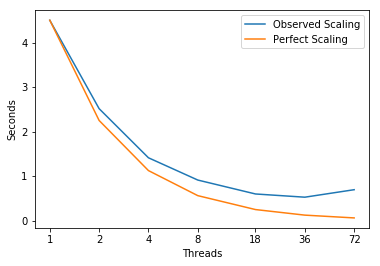

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[4.5, 2.515, 1.4125, 0.9125, 0.6, 0.5277777777777778, 0.6958333333333334],
        label='Observed Scaling')
ax.plot(Threads, [4.5, 2.25, 1.125, 0.5625, 0.25, 0.125, 0.0625],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |        1.6          |         4.7% |         21.3% |      4.7% |                1.23     |       23.4% |        6.6%  |       0.7%    |
| 72                           |  100.0 %   |       0.99          |         2.3% |         24.9% |      0.0% |                0.35     |        6.2% |        2.1%  |       0.0%    |

## sparseX2( )
| sparseX2 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:---------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1              |  92.9 %   |        1.6          |         4.8% |         21.3% |      1.2% |                1.28     |       24.6% |        7.0%  |       0.2%    |
| 72             |  26.9 %   |        1.8          |         4.8% |         24.9% |      0.0% |                0.58     |       22.9% |        7.9%  |       0.0%    |

```c
 15 // \details
 16 // Sparse matrix multiply X^2
 17 void sparseX2(real_t* trX, real_t* trX2, struct SparseMatrixSt* xmatrix, struct SparseMatrixSt* x2matrix, struct DomainSt* domain)
 18 {
 19   int hsize = xmatrix->hsize;
 20   int ix[hsize];
 21   real_t x[hsize];
 22   real_t traceX = ZERO;
 23   real_t traceX2 = ZERO;
 24 
 25   memset(ix, 0, hsize*sizeof(int));
 26   memset(x, ZERO, hsize*sizeof(real_t));
 27 
 28   #pragma omp parallel for firstprivate(ix,x) reduction(+:traceX,traceX2)
 29   for(int i = domain->localRowMin; i < domain->localRowMax; i++)
 30   // CALCULATES THRESHOLDED X^2
 31   {
 32     int l = 0;
 33     for(int jp = 0; jp < xmatrix->iia[i]; jp++)
 34     {
 35       real_t a = xmatrix->val[i][jp];
 36       int j = xmatrix->jja[i][jp];
 37       if (j == i)
 38       {
 39         traceX += a;
 40       }
 ```
 | loop at sparseMath.c: 41 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                        |  86.0 %   |        1.6          |         5.0% |         21.3% |      1.3% |                1.28     |       25.3% |        7.2%  |       0.2%    |
| 72                       |  24.6 %   |        1.8          |         4.8% |         24.8% |      0.0% |                0.60     |       23.3% |        8.0%  |       0.0%    |
 ```c
 41       for(int kp = 0; kp < xmatrix->iia[j]; kp++)
 42       {
 43         int k = xmatrix->jja[j][kp];
 44         if (ix[k] == 0)
 45         {
 46           x[k] = ZERO;
 47           x2matrix->jja[i][l] = k;
 48           ix[k] = i+1;
 49           l++;
 50         }
 51         x[k] = x[k] + a * xmatrix->val[j][kp]; // TEMPORARY STORAGE VECTOR LENGTH FULL N
 52       }
 53     }
 54 
 55     int ll = 0;
 56     for(int j = 0; j < l; j++)
 57     {
 58       int jp = x2matrix->jja[i][j];
 59       real_t xtmp = x[jp];
 60       if (jp == i)
 61       {
 62         traceX2 += xtmp;
 63         x2matrix->val[i][ll] = xtmp;
 64         x2matrix->jja[i][ll] = jp;
 65         ll++;
 66       }
 67       else if(ABS(xtmp) > eps)
 68       {
 69         x2matrix->val[i][ll] = xtmp;
 70         x2matrix->jja[i][ll] = jp;
 71         ll++;
 72       }
 73       ix[jp] = 0;
 74       x[jp] = ZERO;
 75     }
 76     x2matrix->iia[i] = ll;
 77   }
 78 
 79   *trX = traceX;
 80   *trX2 = traceX2;
 81 
 82 }
```


Significant amount of time spent on thread barriers in openMP library.  Hyper-Threading having a negative affect on runtime.  
*TODO: Look into Threaded Performance without Hyper-Threading*

schedule(dynamic) bumped to 35.8%, schedule(guided) bumped to 35.5%